#### Checklist
##### Cleaning
- [] check unique values for each columns  
- [] remove oulier (percentile)  
- [] remove unused columns  
- [] check empty, none, nan values, white spaces (regex)  

##### Additional datas
- [] add province and zip code (external csv datas)  


#### Questions

- percentage of houses by provinces within a budget  
- price per sq meters by price  
- 
- graph heatmap over belgium (price/sqmeter)  


In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
# import geopandas as gpd
#_____________________________________________________________________________

from scripts.colors import bcolors as bc

In [66]:
file = './datas/Immoweb_data_ok_maite.csv'
data = pd.read_csv(file)
data.head(50)

,Id,Locality,House or appartment?,Subtype,Price,Type of sale,Number of rooms,Living area,Fully equipped kitchen,Furnished,Open fire,Terrace,Area of terrace,Garden,Area of garden,Land surface,Number of facades,Swimming pool,State of building
0,10233388,Uccle,HOUSE,HOUSE,1295000.0,BUY_REGULAR,4.0,290.0,1,None,0,1,15,None,None,230,2,0,GOOD
1,10311296,Woluwe-Saint-Pierre,APARTMENT,APARTMENT,150000.0,PUBLIC_SALE,2.0,65.0,0,None,0,1,None,None,None,None,None,None,None
2,10310451,Anderlecht,APARTMENT,APARTMENT,357500.0,BUY_REGULAR,3.0,119.0,0,None,0,1,16,None,None,None,4,None,NaN
3,10309870,Uccle,APARTMENT,APARTMENT,295000.0,BUY_REGULAR,2.0,140.0,0,None,0,None,None,None,None,None,2,None,TO_BE_DONE_UP
4,10309546,Uccle,APARTMENT,APARTMENT,199000.0,BUY_REGULAR,1.0,61.0,0,None,0,1,2,None,None,None,2,None,NaN
5,10308639,Berchem-Sainte-Agathe,HOUSE,HOUSE,485000.0,BUY_REGULAR,3.0,235.0,0,None,0,None,None,1,100,200,2,0,TO_BE_DONE_UP
6,10307653,SINT-GILLIS,HOUSE,HOUSE,595000.0,BUY_REGULAR,7.0,276.0,0,None,0,None,None,1,None,0,2,None,TO_BE_DONE_UP
7,10306812,Forest,APARTMENT,APARTMENT,239000.0,BUY_REGULAR,2.0,87.0,None,None,0,1,15,None,None,None,2,None,TO_BE_DONE_UP
8,10305775,Uccle,HOUSE,HOUSE,386000.0,BUY_REGULAR,3.0,100.0,None,None,0,None,None,None,None,0,2,0,NaN
9,10305006,Brussels City,APARTMENT,APARTMENT,295000.0,BUY_REGULAR,2.0,72.0,0,None,0,1,4,None,None,NaN,4,None,NaN


1. Check for duplicated rows in the df

In [67]:
data.duplicated()

# data_duplicated = data[data.duplicated(subset='Id') == True]
# data_duplicated.head(15)
data.isnull().sum()

Id                           0
Locality                     0
House or appartment?         0
Subtype                      0
Price                     7106
Type of sale                 0
Number of rooms            116
Living area               3235
Fully equipped kitchen       0
Furnished                    0
Open fire                    0
Terrace                      0
Area of terrace              0
Garden                       0
Area of garden               0
Land surface              4424
Number of facades         6696
Swimming pool                0
State of building         7343
dtype: int64

### Cleaning data



1. Replace 'none' values with pd.NA
2. Remove rows where the price is missing

In [68]:
data.replace(np.NaN,'None', inplace=True)
data.replace('None', pd.NA, inplace=True)
data.head()
data = data.drop(data[data['Price'].isna()].index)
data.shape[0]
# data.head()
# data.drop_duplicates('Id')
# data.duplicated().value_counts()

16280

2. Remove data from apartment_group and house_group

In [69]:
data[data['House or appartment?'] == 'APARTMENT_GROUP'].count()
data.drop(data[data['House or appartment?'] == 'APARTMENT_GROUP'].index, inplace=True)
data[data['House or appartment?'] == 'HOUSE_GROUP'].count()
data.drop(data[data['House or appartment?'] == 'HOUSE_GROUP'].index, inplace=True)

data['House or appartment?'].unique()


array(['HOUSE', 'APARTMENT'], dtype=object)

3. Check subtype: remove all unnecessary subtypes.  
Only keep Houses and Apartment subtype for the analysis

In [70]:
# Define array with the value of Subtype to keep.
array = ["HOUSE", "APARTMENT"]
# Drop all rows where subtype is not in the array
data.drop(data.loc[~data['Subtype'].isin(array)].index, inplace=True)

data['Subtype'].unique()



array(['HOUSE', 'APARTMENT'], dtype=object)

4. Remove rows wher surface area is missing

In [71]:
data['Number of rooms'].unique()
data['Number of rooms'].describe([.7,.8,.9,.99])

count     12109.0
unique       19.0
top           2.0
freq       4412.0
Name: Number of rooms, dtype: float64

### Add new columns
    -price sq meter

In [72]:
# Remove rows where Living area is missing
data.drop((data[data['Living area'].isna()].index), inplace=True)
# Check if no more rows with missing 'Living area'
data['Living area'].isna().sum()

# Creat new column with price per square meter
data['price_square_meters'] = (data['Price'] / data['Living area'])
# Make sure the data type of the new column is numeric
data['price_square_meters'] = (pd.to_numeric(data['price_square_meters'], errors='coerce')).round(2)

data['price_square_meters'].info()


<class 'pandas.core.series.Series'>
Int64Index: 10450 entries, 0 to 23380
Series name: price_square_meters
Non-Null Count  Dtype  
--------------  -----  
10450 non-null  float64
dtypes: float64(1)
memory usage: 163.3 KB


In [73]:
### Correlation

C:\Users\meule\AppData\Local\Temp\ipykernel_4964\2930521174.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


<AxesSubplot: >

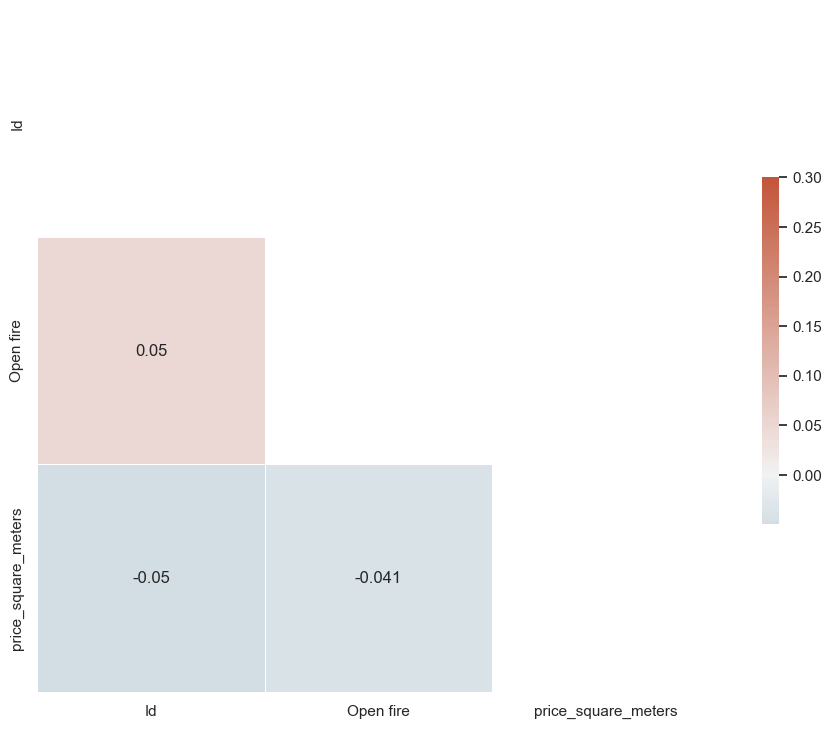

In [74]:
sns.set_theme(style="white")

# Generate a large random dataset

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

#### Remove outliers from Price and price_square_meters

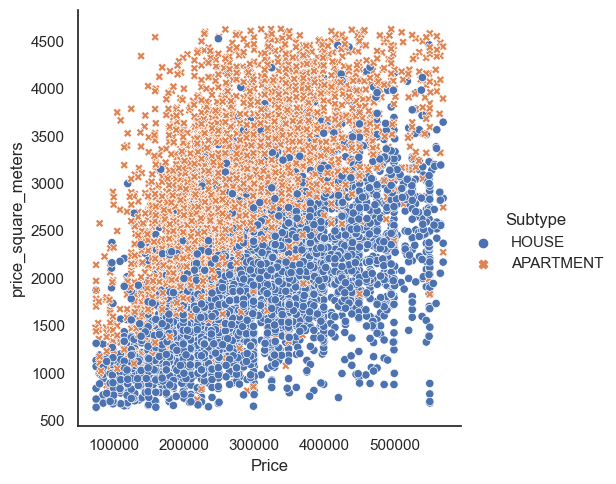

In [75]:



q1_price , q3_price = data['Price'].quantile([0.25,0.75])
iqr_price = q3_price - q1_price
q1_pricesqm , q3_pricesqm = data['price_square_meters'].quantile([0.25,0.75])
iqr_pricesqm = q3_pricesqm - q1_pricesqm

iqr_coef = 1
data = data[(data['Price'] > (q1_price - iqr_coef*iqr_price)) & (data['Price'] < ((q3_price + iqr_coef*iqr_price)))]
data = data[(data['price_square_meters'] > (q1_pricesqm - iqr_coef*iqr_pricesqm)) & (data['price_square_meters'] < ((q3_pricesqm + iqr_coef*iqr_pricesqm)))]
# data['Living area'].dtypes
# data['price_square_meters'].dtypes
g_price = sns.relplot(x='Price', y='price_square_meters',hue='Subtype',hue_order=['HOUSE','APARTMENT'], kind='scatter', style="Subtype", style_order=['HOUSE','APARTMENT'],  data=data)

g_price
plt.show()


# g_price.set(xlim=(0,10000))



UFuncTypeError: Cannot cast ufunc 'svd_n_s' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

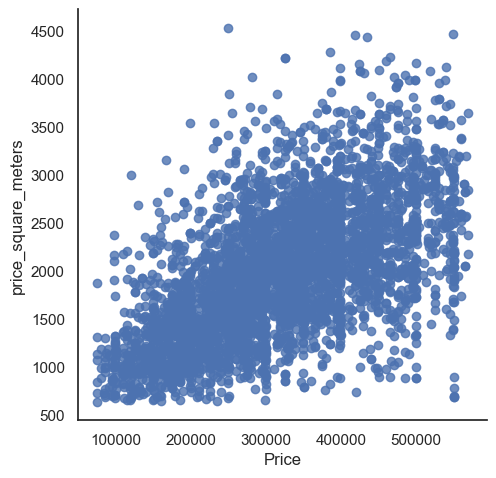

In [76]:
data['price_square_meters'].isna().sum()
g_price_linearreg = sns.lmplot(x='Price', y='price_square_meters',hue='Subtype',hue_order=['HOUSE','APARTMENT'], data=data)
print(type(g_price_linearreg))
# plt.xlim(0,10000)
plt.xticks(rotation=90)
plt.show()

# check pricesq meter is float64
#  TBD: Quantile for the two datas, in a function

#  Do a boxplot of ap and houses price, mean, iqr,std, outliers


### Create a csv file giving the price per square meter by post code